In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import stdata
from stdata.vis.spacetime import SpaceTimeVisualise
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

In [3]:
from vis import DATA_PATH, RESULTS_PATH, RESULTS_FILE
from vis import load_data, load_results, fix_df_columns

# Load data and results 

In [234]:
def load_data_and_results():
    training_data, testing_data, raw_data = load_data()

    train_laqn_df = fix_df_columns(raw_data["train"]["laqn"]["df"])
    test_laqn_df = fix_df_columns(raw_data["test"]["laqn"]["df"])

    hexgrid_df = fix_df_columns(raw_data["test"]["hexgrid"]["df"])

    # Load results
    results = load_results()

    train_laqn_df["pred"] = results["predictions"]["train_laqn"]["mu"][0].astype(np.float64)
    train_laqn_df["var"] = results["predictions"]["train_laqn"]["var"][0].astype(np.float64)
    train_laqn_df["observed"] = train_laqn_df["NO2"].astype(np.float64)
    train_laqn_df['NO2'] = train_laqn_df['NO2'].astype(np.float64)

    test_laqn_df["pred"] = results["predictions"]["test_laqn"]["mu"][0].astype(np.float64)
    test_laqn_df["var"] = results["predictions"]["test_laqn"]["var"][0].astype(np.float64)
    test_laqn_df["observed"] = np.NaN

    laqn_df = pd.concat([train_laqn_df, test_laqn_df])
    laqn_df['NO2'] = laqn_df['NO2'].astype(np.float64)
    laqn_df['pred'] = laqn_df['pred'].astype(np.float64)

    hexgrid_df = gpd.GeoDataFrame(
        hexgrid_df, geometry=gpd.points_from_xy(hexgrid_df["lon"], hexgrid_df["lat"])
    )
    hexgrid_df["geom"] = hexgrid_df["geometry"].buffer(0.002)

    hexgrid_df["pred"] = results["predictions"]["hexgrid"]["mu"][0]
    hexgrid_df["var"] = results["predictions"]["hexgrid"]["var"][0]



    train_sat_df = fix_df_columns(raw_data['train']['sat']['df'].copy())
    train_sat_df['NO2'] = train_sat_df['NO2'].astype(np.float64)
    train_sat_df['observed'] = train_sat_df['NO2'].astype(np.float64)
    
    laqn_df['datetime'] = pd.to_datetime(laqn_df['measurement_start_utc'])
    train_sat_df['datetime'] = pd.to_datetime(train_sat_df['measurement_start_utc'])
    hexgrid_df['datetime'] = pd.to_datetime(hexgrid_df['measurement_start_utc'])


    return results, training_data, testing_data, raw_data, laqn_df, train_sat_df, hexgrid_df

In [235]:
results, training_data, testing_data, raw_data, laqn_df, sat_df, hexgrid_df = load_data_and_results()

# Training Metrics

In [239]:
print('LAQN Training Metrics')
results['metrics']['train_laqn_0']

LAQN Training Metrics


{'mae': 18.594060629817868,
 'mse': 665.2440097677888,
 'rmse': 25.792324629001335,
 'r2_score': 0.048935529584422266}

In [243]:
print('Satellite Training Metrics')
results['metrics']['sat_0']

Satellite Training Metrics


{'mae': 3.302560866813693,
 'mse': 22.820218645346145,
 'rmse': 4.777051250022983,
 'r2_score': 0.7946519345913229}

# Basic data vis

In [106]:
# spatial plots of satellite

In [107]:
def make_gdf(df):
    return gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df["lon"], df["lat"])
    )

In [179]:
def get_sat_area(sat_df):
    # convert id to a numeric
    sat_df['gid'] = sat_df.groupby('id').ngroup()

    sat_df = sat_df[['box_id', 'datetime', 'lat', 'lon', 'NO2', 'gid']].groupby(['datetime', 'box_id']).mean().reset_index().copy()
    sat_df = make_gdf(sat_df)
    # quick hack to get the area of the satellite data
    sat_df["geometry"] = sat_df["geometry"].buffer(0.05,  cap_style = 3)
    return sat_df

In [109]:
datetime_to_plot = sat_df.iloc[0]['measurement_start_utc']
sub_sat_df = sat_df[
    sat_df['measurement_start_utc'] == datetime_to_plot
].copy()
sub_laqn_df = laqn_df[
    laqn_df['measurement_start_utc'] == datetime_to_plot
].copy()

In [150]:
sub_sat_area_df = get_sat_area(sub_sat_df)

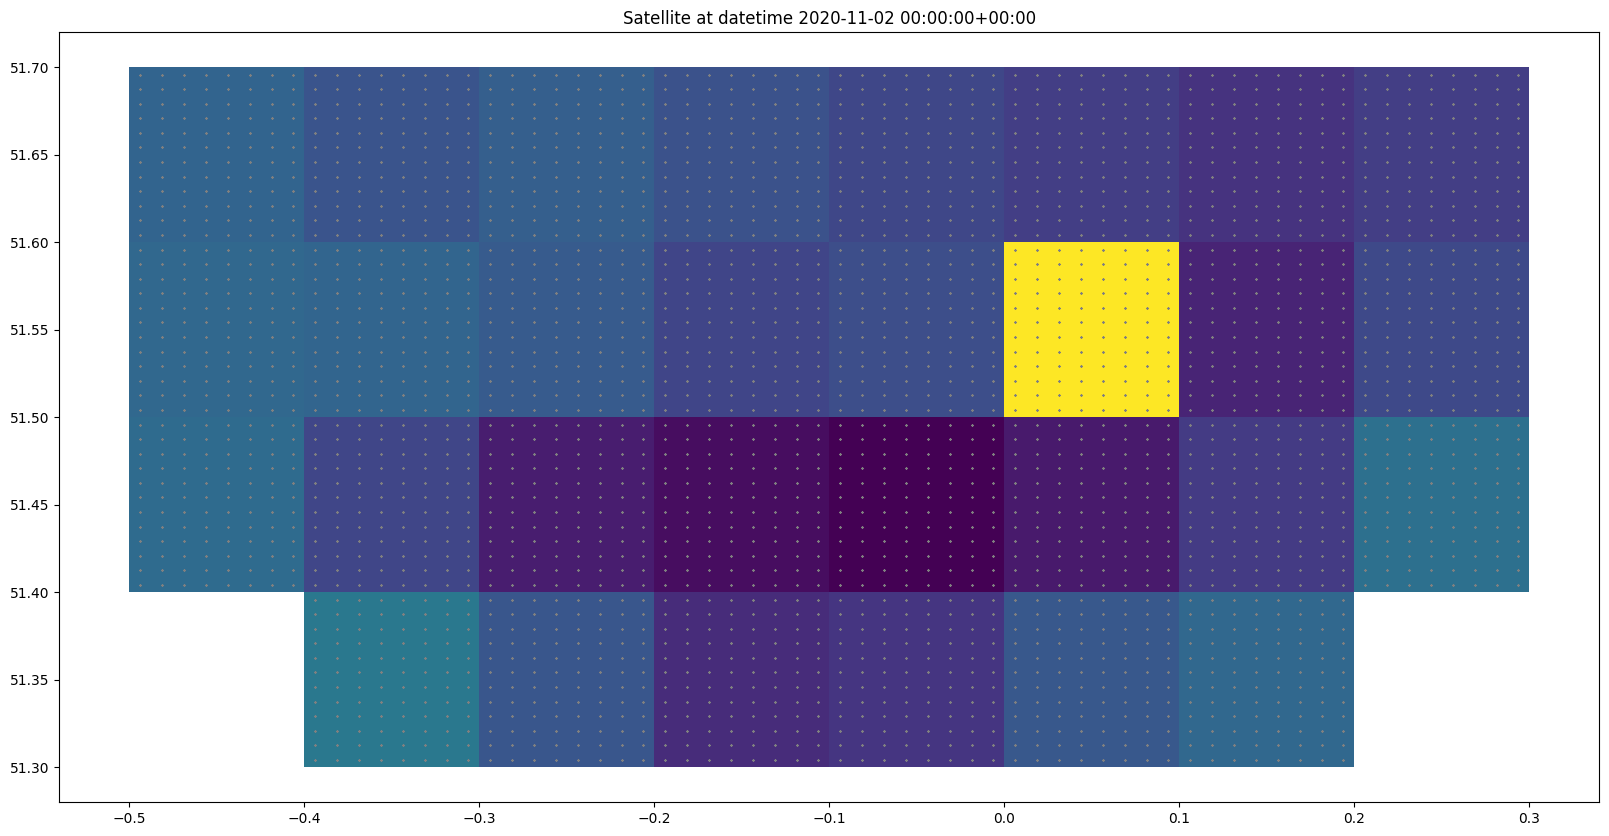

In [151]:
fig = plt.figure(figsize=(20, 10))
plt.title(f'Satellite at datetime {datetime_to_plot}')
ax = plt.gca()
sub_sat_area_df.plot(ax=ax, column='NO2')
plt.scatter(sub_sat_df['lon'], sub_sat_df['lat'], marker='x', s=1.0, c='grey')

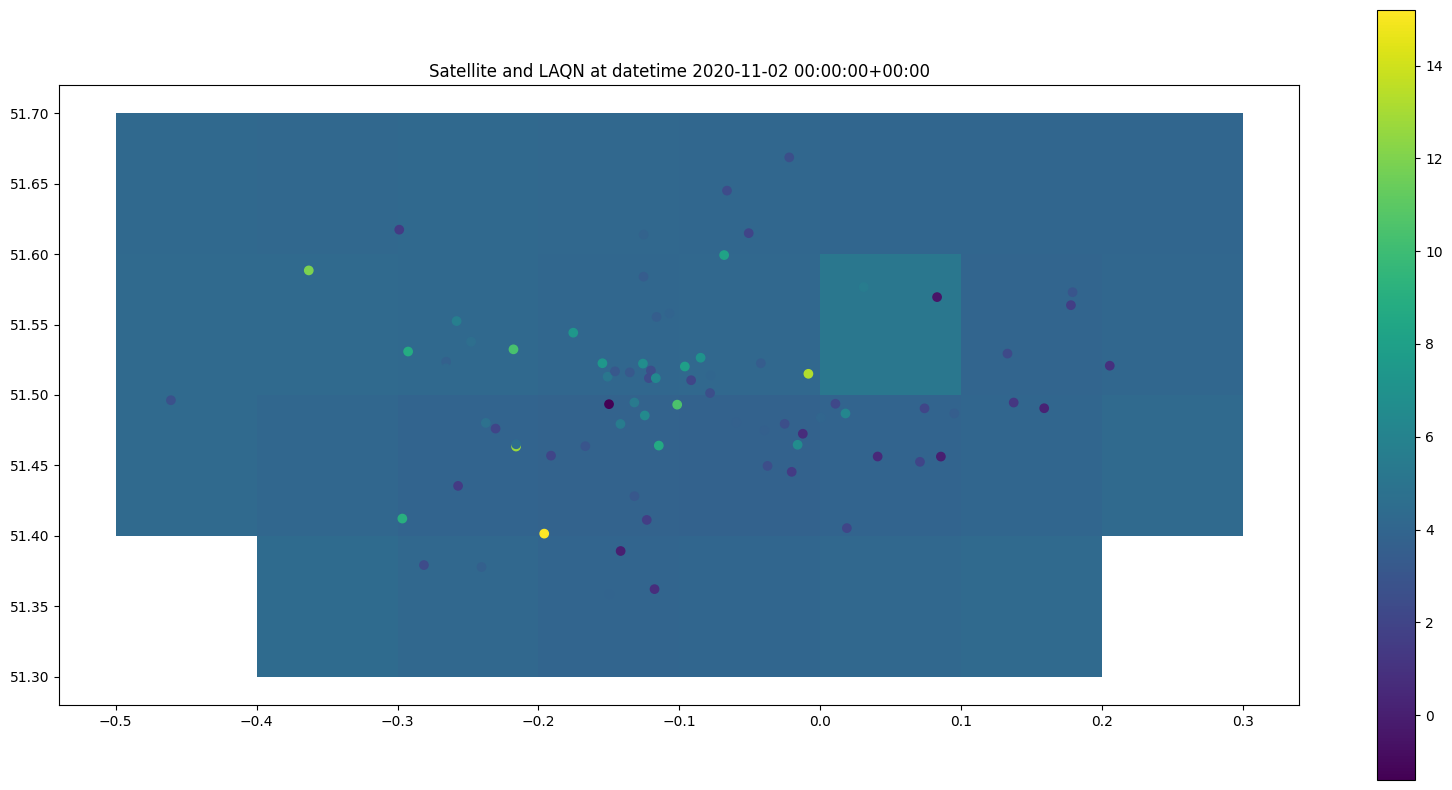

In [112]:
fig = plt.figure(figsize=(20, 10))
plt.title(f'Satellite and LAQN at datetime {datetime_to_plot}')
ax = plt.gca()
norm = Normalize(vmin=np.min(sub_laqn_df['NO2']), vmax=np.max(sub_laqn_df['NO2']))

sub_sat_area_df.plot(ax=ax, column='NO2', norm=norm, legend=True)
plt.scatter(sub_laqn_df['lon'], sub_laqn_df['lat'], c=sub_laqn_df['NO2'], norm=norm)

# Plot calibration function for a single sensor

In [204]:
def get_sat_data_for_sensor(sat_df, laqn_df):
    # get all sat data for the single time series in laqn_df
    
    # first get the sjoin at a single timepoint
    sub_sat = sat_df[sat_df['datetime'] == laqn_df['datetime'].iloc[0]]
    sub_sat = sub_sat[['geometry', 'gid']].sjoin(single_timeseries_laqn_df, lsuffix='sat', rsuffix='laqn')
    found_gid = sub_sat['gid'].iloc[0]
    sub_sat_df = sat_df[sat_df['gid'] == found_gid]
    
    # merge on datetime
    joined_df =  laqn_df.merge(sub_sat_df, on='datetime', suffixes=['_laqn', '_sat'])
    # sort by datetime for plotting
    return joined_df.sort_values(by='datetime')

In [180]:
laqn_df = make_gdf(laqn_df).copy()
sat_gdf = get_sat_area(sat_df).copy()

In [182]:
single_timeseries_laqn_df = laqn_df[laqn_df['id'] == laqn_df.iloc[0]['id']].copy()

In [205]:
joined_df = get_sat_data_for_sensor(sat_gdf, single_timeseries_laqn_df)

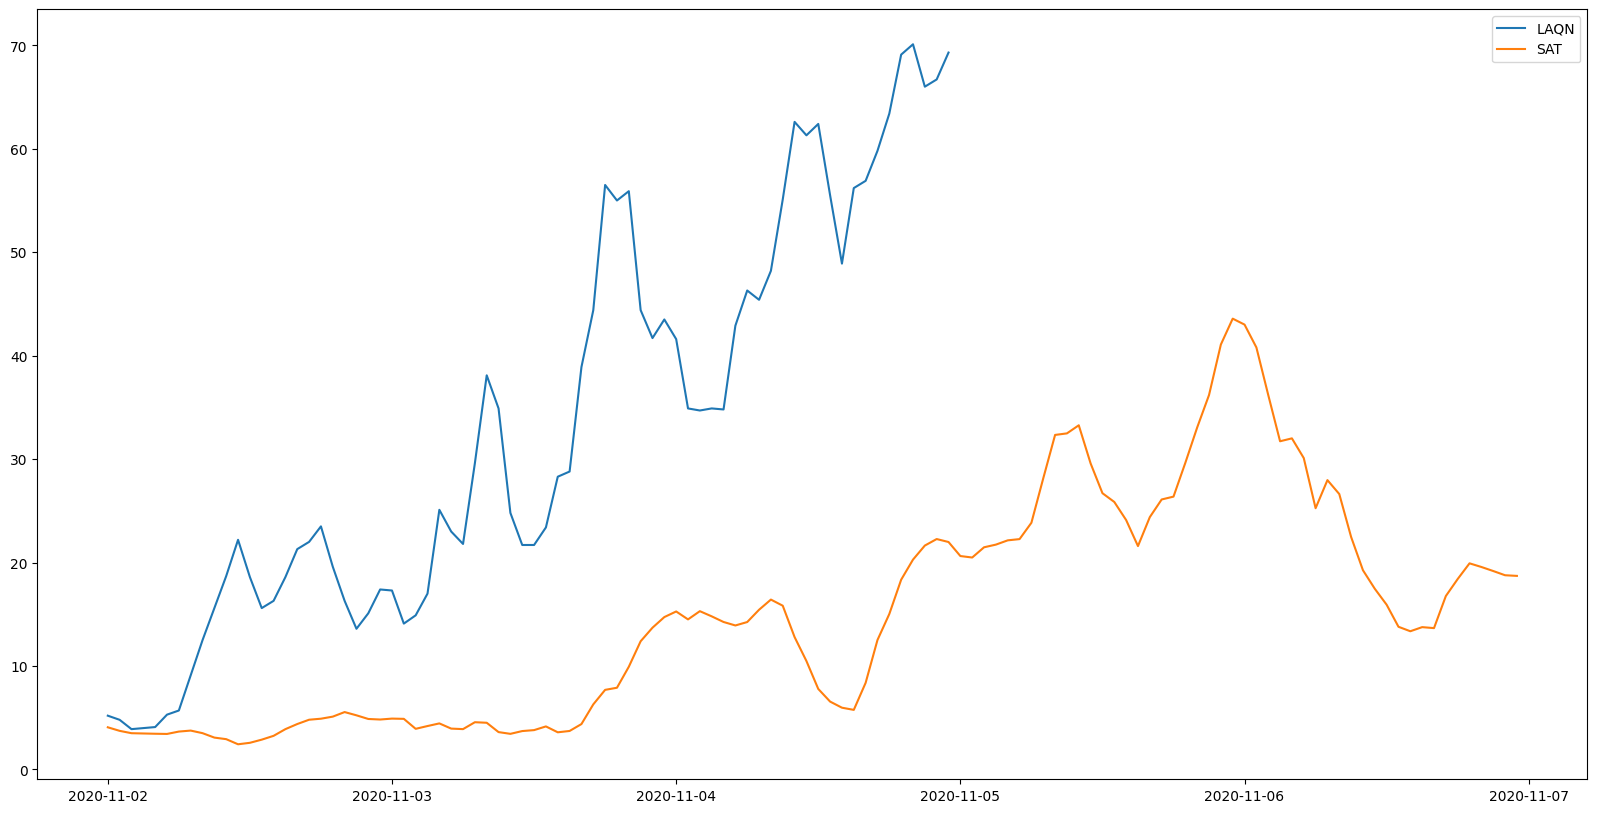

In [214]:
plt.figure(figsize=(20, 10))
plt.plot(
    joined_df['datetime'], joined_df['NO2_laqn'], label='LAQN'
)

plt.plot(
    joined_df['datetime'], joined_df['NO2_sat'], label='SAT'
)

plt.legend()

# plot calibration function

Text(0, 0.5, 'no2')

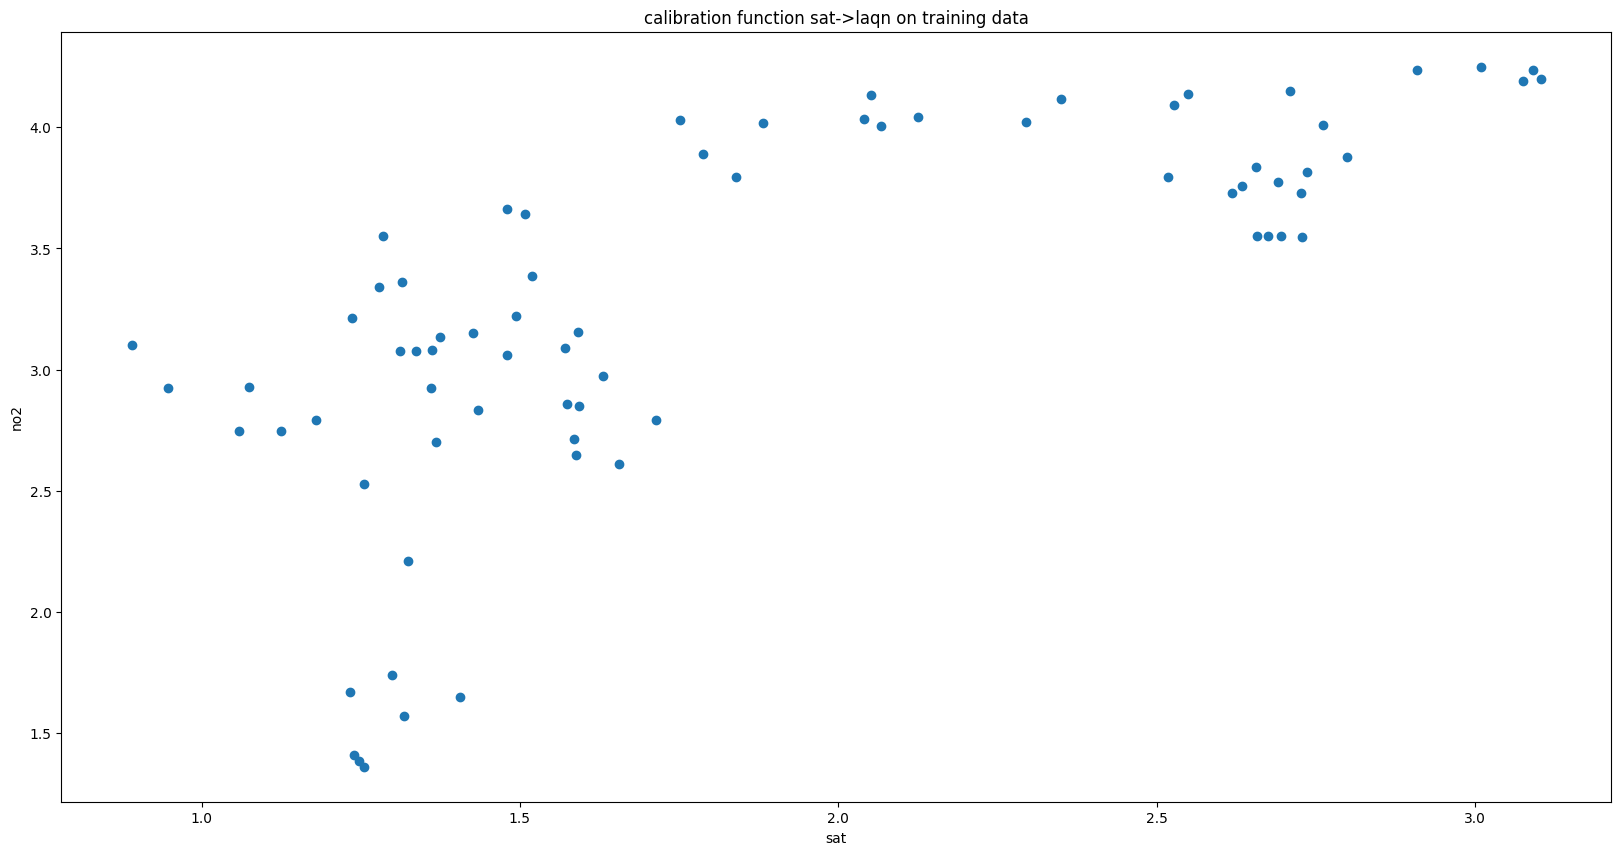

In [247]:
plt.figure(figsize=(20, 10))
plt.title('calibration function sat->laqn on training data')
plt.scatter(
    np.log(joined_df['NO2_sat']),
    np.log(joined_df['NO2_laqn']),
)
plt.xlabel('sat')
plt.ylabel('no2')

# plot all laqn data and sat data

Text(0.5, 1.0, 'All LAQN')

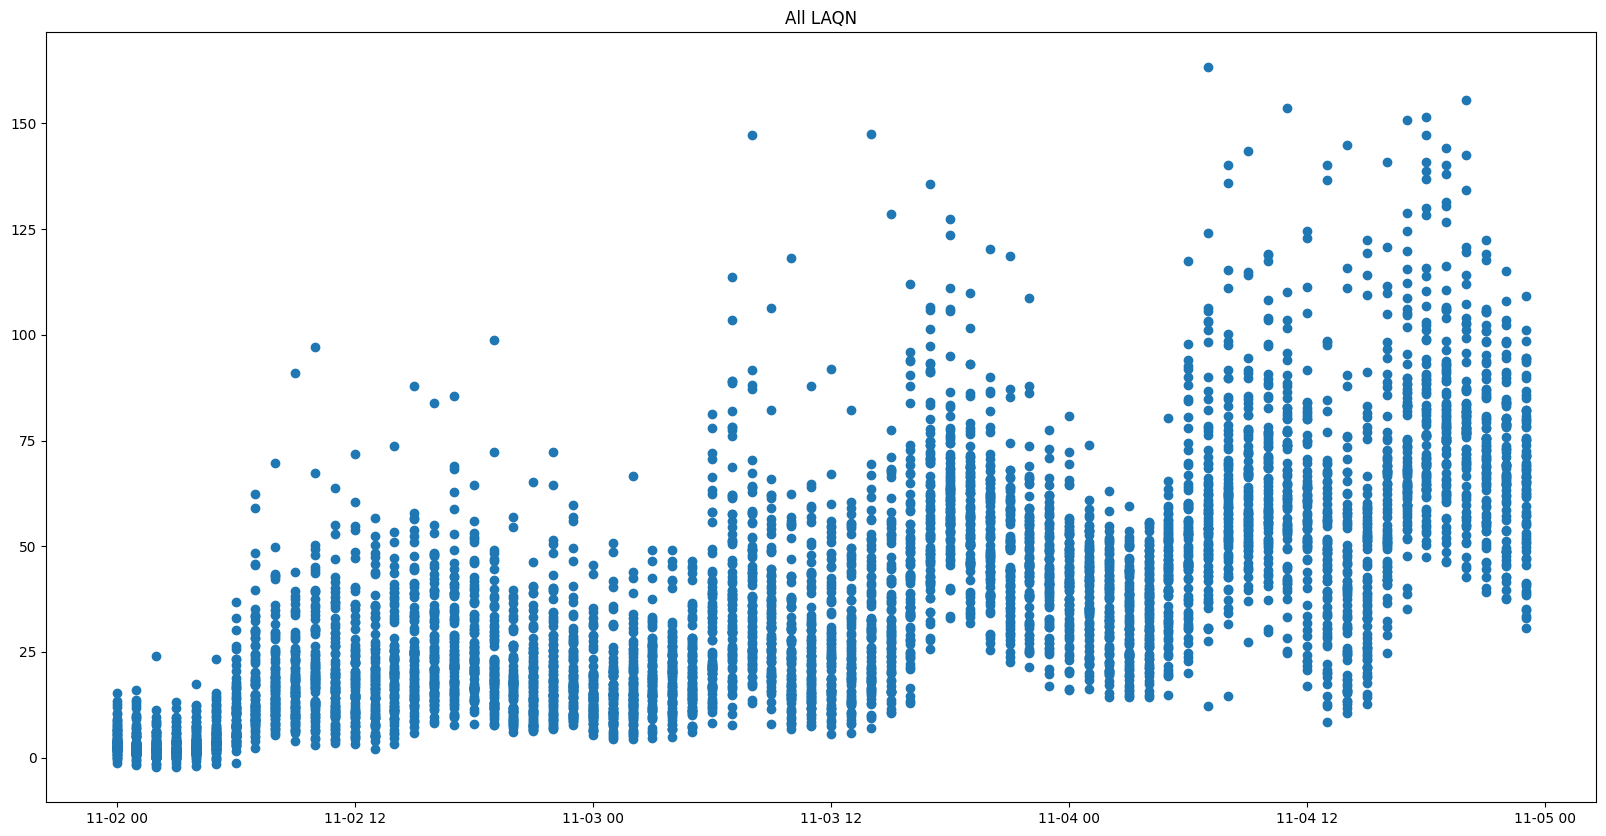

In [216]:
plt.figure(figsize=(20, 10))
plt.scatter(
    laqn_df['datetime'],
    laqn_df['NO2']
)
plt.title('All LAQN')

Text(0.5, 1.0, 'All SAT')

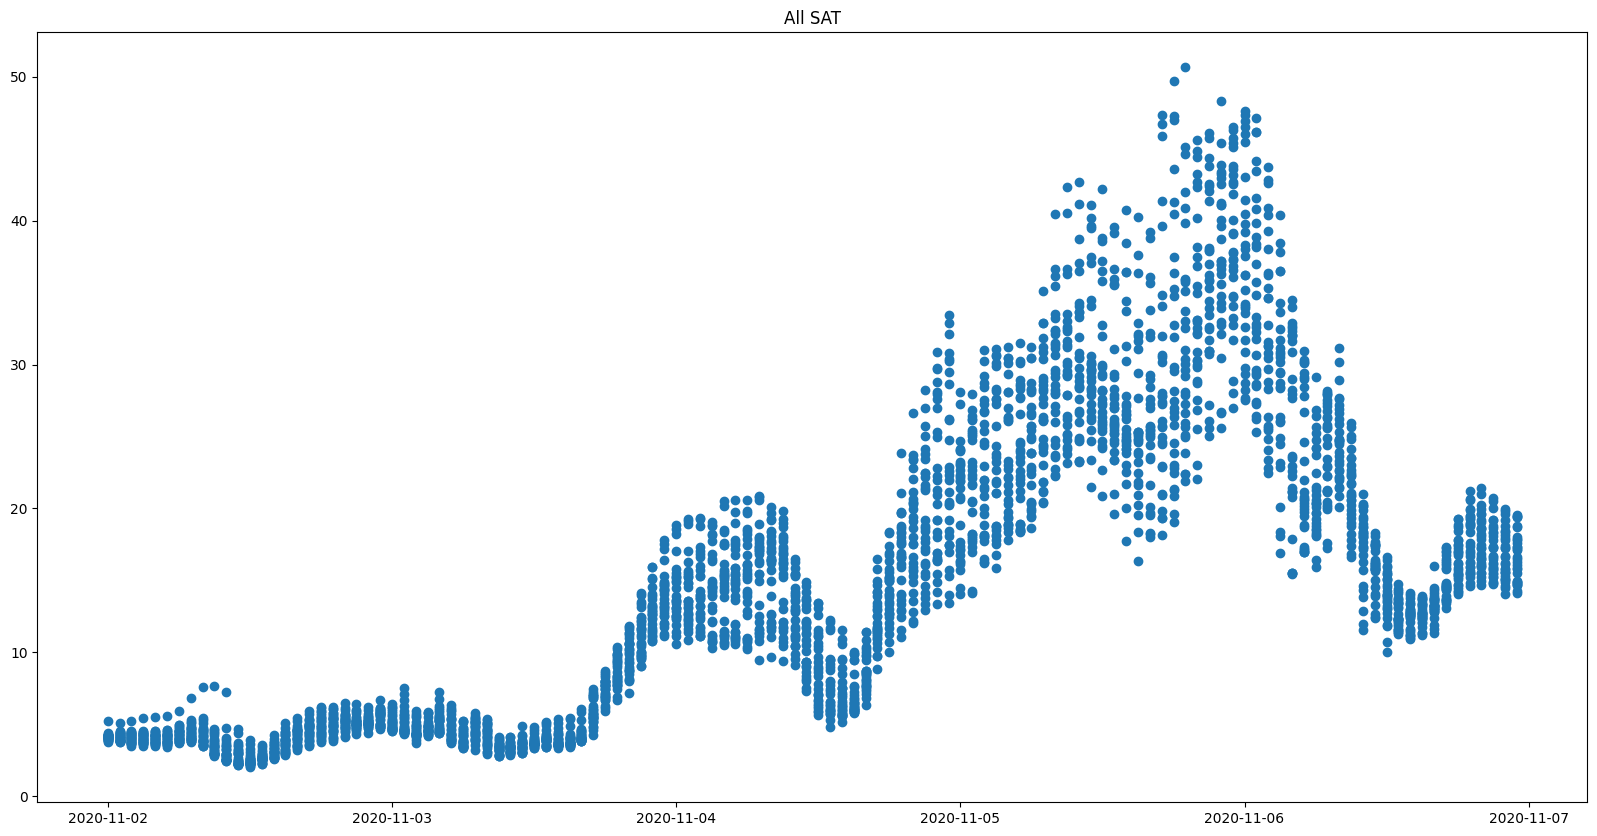

In [219]:
plt.figure(figsize=(20, 10))
plt.scatter(
    sat_gdf['datetime'],
    sat_gdf['NO2']
)
plt.title('All SAT')

Text(0.5, 1.0, 'All LAQN + SAT')

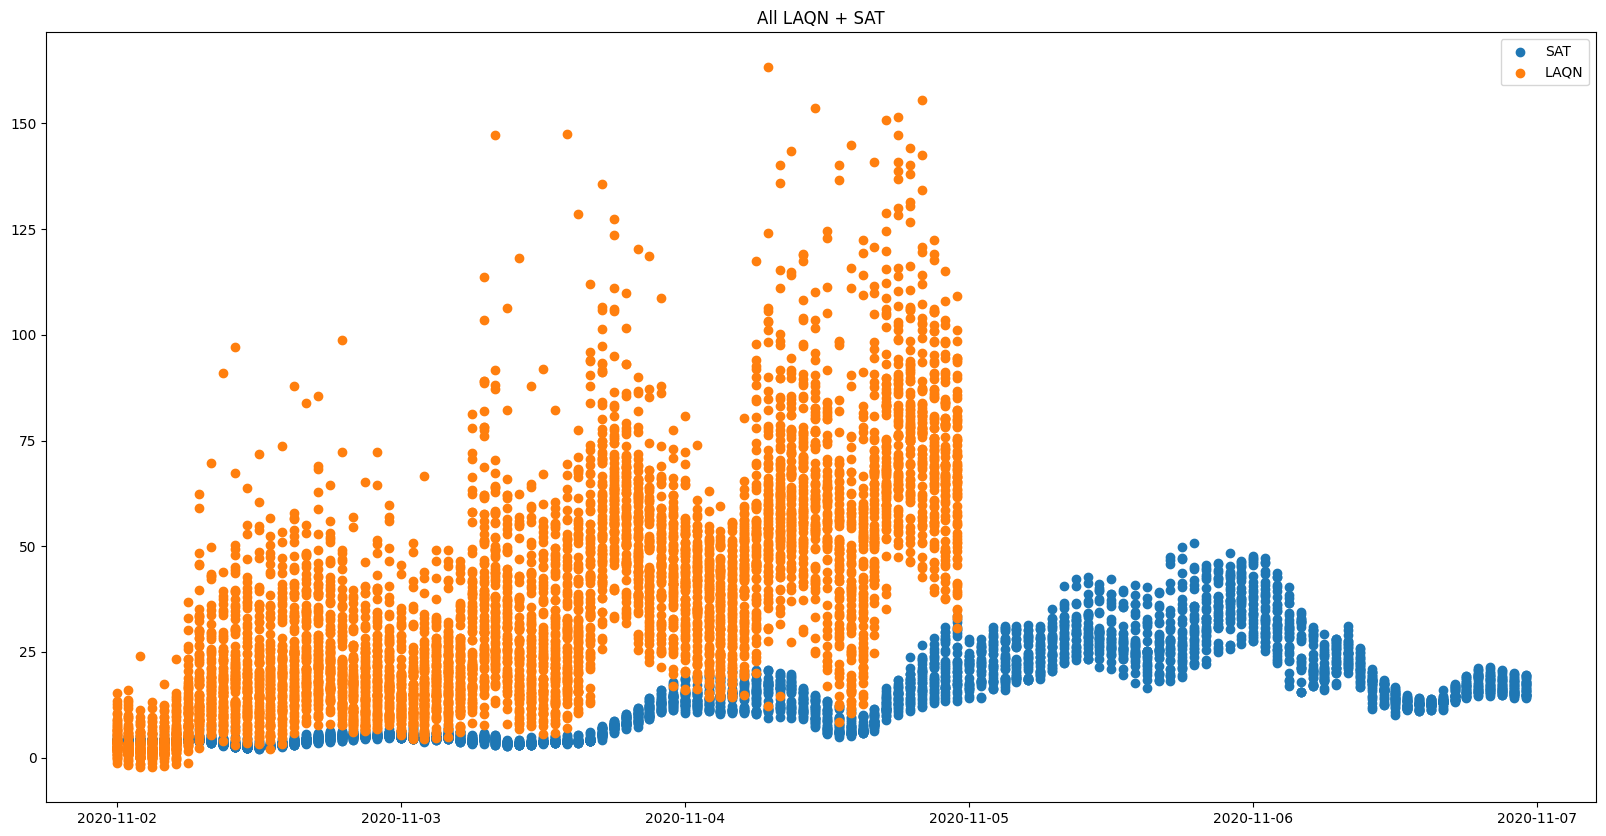

In [220]:
plt.figure(figsize=(20, 10))



plt.scatter(
    sat_gdf['datetime'],
    sat_gdf['NO2'],
    label='SAT'
)

plt.scatter(
    laqn_df['datetime'],
    laqn_df['NO2'],
    label='LAQN'
)
plt.legend()
plt.title('All LAQN + SAT')

# Plot all calibration functions

In [223]:
all_laqn_ids = laqn_df['id'].unique()

all_joined_df_list = [
    get_sat_data_for_sensor(sat_gdf, laqn_df[laqn_df['id'] == laqn_id].copy())
    for laqn_id in all_laqn_ids
]

In [229]:
print(f'number of laqn sites: ', len(all_laqn_ids))

number of laqn sites:  96


In [ ]:
plt.figure(figsize=(20, 10))
for i in range(len(all_laqn_ids)):
    plt.scatter(
        np.log(all_joined_df_list[i]['NO2_sat']),
        np.log(all_joined_df_list[i]['NO2_laqn']),
    )
plt.xlabel('sat')
plt.ylabel('laqn')

/usr/local/anaconda3/envs/stgp_ex/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/anaconda3/envs/stgp_ex/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'laqn')